# Light Exposure in the Lobby

The parameter for this project is light. The LM393 light sensor is used to detect light levels in the lobby and this will provide a digital output by comparing the input light level against a reference voltage. This gives a binary signal where the output is 0 (high) or 1 (low) depending on whether the light intensity is above or below the threshold. The binary time series data on light intensity in the NIC building lobby is collected within one day from 13:00 pm to 17:00 pm. This data is stored in Mongodb atlas and analyzed using aggregate pipelines.

Hardware Setup

The LM393 sensor was connected to the esp32 microcontroller to gather and process sensor data. The used LM393 sensor has three pins - VCC, GND and DO.
VCC - This pin provides power supply to the sensor. It was connected to the 3.3V pin on the esp32.
GND - This pin is the ground connection for the sensor. It was connected to the GND pin on the esp32.
DO - This pin outputs the digital signal from the sensor. It was connected to GPIO 34 pin on the esp32.
The connections between the LM393 sensor and the esp32 were made using a solderless breadboard.

Data flow of the IoT system

The LM393 light sensor detects light intensity in the lobby and gives a digital binary signal based on its threshold.
The light sensor sends the digital output signal to the esp32 through the digital output (DO) pin and the esp32 reads these binary signals every minute.
The esp32 processes the binary signal to determine if the light level is above or below the threshold and formats the data with a timestamp. 
The esp32 connects to the wifi network and sends processed light data to mongodb atlas over the network. 
Mongodb atlas receives the incoming data from the esp32 and stores it in its collection named light_readings and each entry contains the light reading, unit and time. 
The stored data in mongodb atlas is retrieved by the data analysis tools for analysis.

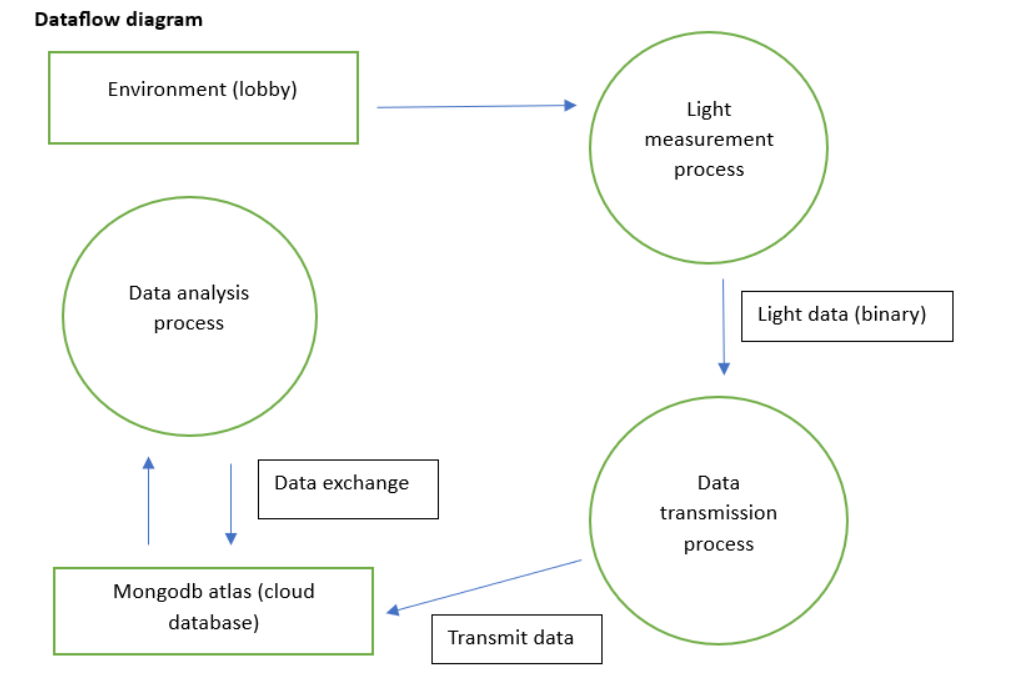

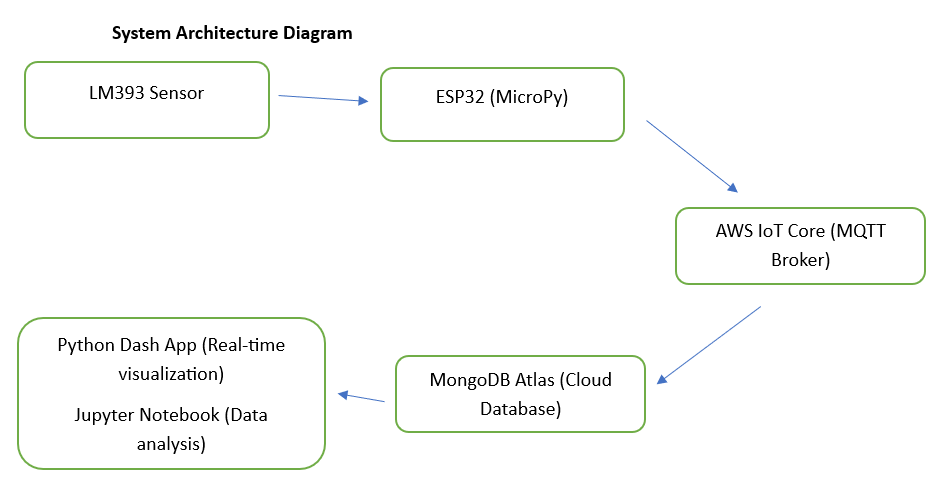

Structure of the Database

The database is named “add232iotdb” and contains a collection called “light_readings” which stores the time series data generated by the LM393 light sensor. 
Each document in the collection represents a single light reading and includes the fields:
_id - a unique identifier.
light_reading - field that records the binary output (0 or 1) of the sensor.
unit - specifies the measurement unit as digital value.
time - includes the timestamp when the reading was taken.

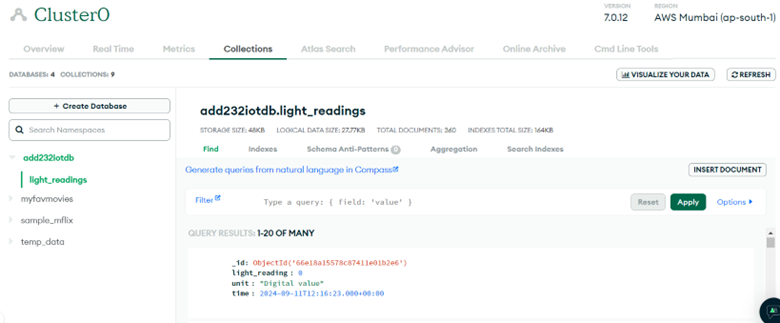

Indexes Implemented

1. Single field index on time.
The time field is needed in querying and analyzing data based on specific time intervals and the single field index on time optimizes these queries. Without the index on the time field, mongodb would need to perform a collection scan where each document is examined to find the documents within a specified time range. This would be inefficient therefore the ascending index on time lets mongodb easily locate documents that match the time criteria improving query performance. 


2. Compound index on light_reading and time.
This compound index would optimize queries that need to filter or aggregate data based on both the light_reading value and time periods. It allows mongodb to efficiently process queries that involve both light_reading and time by enabling fast lookups and reducing the number of documents that need to be scanned. 


The time field is converted from a string to ISODate format for efficient date based queries and aggregation.
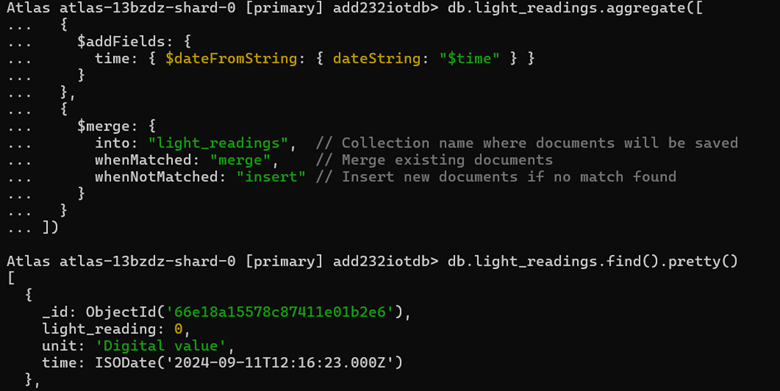

### Aggregate Pipelines and Visualizations

In [ ]:
# Connecting to mongodb
from pymongo import MongoClient
import pandas as pd
from urllib.parse import quote_plus

# password = quote_plus("")

# client = MongoClient(f"")

db = client['add232iotdb']
collection = db['light_readings']

import warnings
from cryptography.utils import CryptographyDeprecationWarning

warnings.filterwarnings("ignore", category = CryptographyDeprecationWarning)

# Retrieve and print all documents
for doc in collection.find():
    print(doc)

{'_id': ObjectId('66e18a15578c87411e01b2e6'), 'light_reading': 0, 'unit': 'Digital value', 'time': datetime.datetime(2024, 9, 11, 12, 16, 23)}
{'_id': ObjectId('66e18a51578c87411e01b2e7'), 'light_reading': 0, 'unit': 'Digital value', 'time': datetime.datetime(2024, 9, 11, 12, 17, 23)}
{'_id': ObjectId('66e18a8d578c87411e01b2e8'), 'light_reading': 0, 'unit': 'Digital value', 'time': datetime.datetime(2024, 9, 11, 12, 18, 23)}
{'_id': ObjectId('66e18ac9578c87411e01b2e9'), 'light_reading': 0, 'unit': 'Digital value', 'time': datetime.datetime(2024, 9, 11, 12, 19, 23)}
{'_id': ObjectId('66e18b05578c87411e01b2ea'), 'light_reading': 0, 'unit': 'Digital value', 'time': datetime.datetime(2024, 9, 11, 12, 20, 23)}
{'_id': ObjectId('66e18b42578c87411e01b2eb'), 'light_reading': 0, 'unit': 'Digital value', 'time': datetime.datetime(2024, 9, 11, 12, 21, 23)}
{'_id': ObjectId('66e18b7e578c87411e01b2ec'), 'light_reading': 0, 'unit': 'Digital value', 'time': datetime.datetime(2024, 9, 11, 12, 22, 23)}

In [4]:
# Time Range for the queries
from datetime import datetime

start_time = datetime(2024, 9, 11, 13, 0, 0)
end_time = datetime(2024, 9, 11, 17, 0, 0)

In [5]:
import matplotlib.pyplot as plt
import numpy as np

#### 1. Count occurrences of light presence and absence

In [ ]:
# This query will count how many times light is present (light_reading = 0) and absent (light_reading = 1) between 13.00 and 17.00. 

In [7]:
pipeline_1 = [
    {"$match": {"time": {"$gte": start_time, "$lte": end_time}}},
    {"$group": {
        "_id": None,
        "lightPresent": {"$sum": {"$cond": [{"$eq": ["$light_reading", 0]}, 1, 0]}},
        "lightAbsent": {"$sum": {"$cond": [{"$eq": ["$light_reading", 1]}, 1, 0]}}
    }}
]

result_1 = list(collection.aggregate(pipeline_1))

print("Count of Light Present and Absent:")
for doc in result_1:
    print(doc)

Count of Light Present and Absent:
{'_id': None, 'lightPresent': 184, 'lightAbsent': 55}


In [8]:
# Therefore, instances of light present was 184 (184 minutes) and light absent was 55 (55 minutes) from 13.00 to 17.00. 

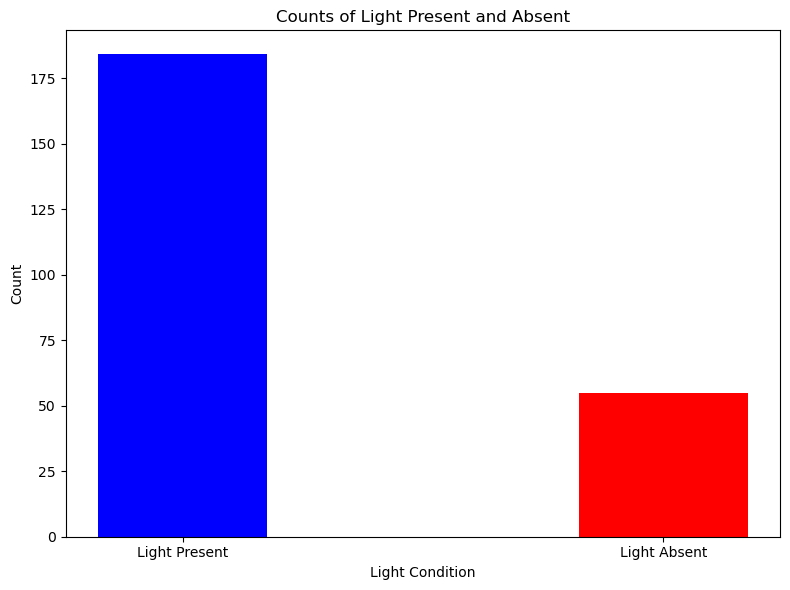

In [9]:
# Grouped column chart for Count occurrences of light presence and absence

lightPresent = result_1[0]['lightPresent']
lightAbsent = result_1[0]['lightAbsent']

categories = ['Light Present', 'Light Absent']
values = [lightPresent, lightAbsent]

bar_width = 0.35

plt.figure(figsize=(8, 6))
index = np.arange(len(categories))
plt.bar(index, values, bar_width, color=['b', 'r'], label=categories)

plt.xlabel('Light Condition')
plt.ylabel('Count')
plt.title('Counts of Light Present and Absent')

plt.xticks(index, categories)

plt.tight_layout()
plt.show()

#### 2. Calculate average light exposure per hour

In [10]:
# This query will calculate the average number of times light is present per hour between 13.00 and 17.00.

In [11]:
pipeline_2 = [
    {"$match": {"time": {"$gte": start_time, "$lte": end_time}}},
    {"$project": {
        "hour": {"$hour": "$time"},
        "lightPresent": {"$cond": [{"$eq": ["$light_reading", 0]}, 1, 0]}
    }},
    {"$group": {
        "_id": "$hour",
        "avgLightPresent": {"$avg": "$lightPresent"}
    }},
    {"$sort": {"_id": 1}}
]

result_2 = list(collection.aggregate(pipeline_2))

print("Average Light Exposure per Hour:")
for doc in result_2:
    print(doc)

Average Light Exposure per Hour:
{'_id': 13, 'avgLightPresent': 0.8833333333333333}
{'_id': 14, 'avgLightPresent': 0.5166666666666667}
{'_id': 15, 'avgLightPresent': 0.9}
{'_id': 16, 'avgLightPresent': 0.7796610169491526}


In [12]:
# Therefore:
# Hour 13 – From 13.00 to 14.00 the average light present value is 0.883 which means 88.3% of records in this hour 
# had light reading equal to 0.
# Hour 14 – From 14.00 to 15.00 the average light present value is 0.517 which means that about 51.7% of records in this 
# hour had light reading equal to 0.
# Hour 15 – From 15.00 to 16.00 the average light present value is 0.9 which means that about 90% of the records in 
# this hour had light reading of 0. 
# Hour 16 – From 16.00 to 17.00 the average light present value is 0.780 which means that 78% of the records in this 
# hour had light reading equal to 0.

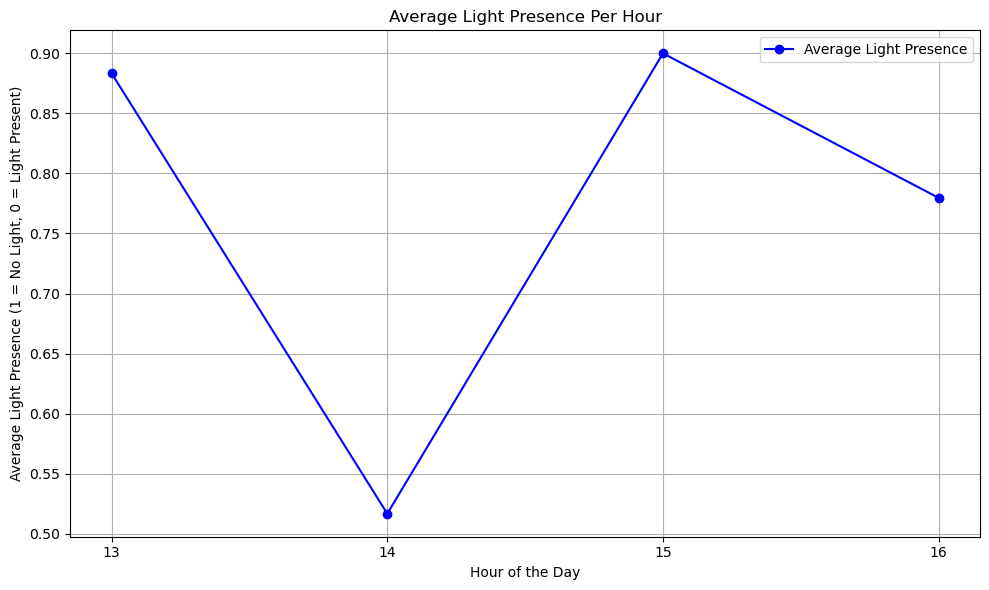

In [13]:
# Discrete line chart for Calculate average light exposure per hour

hours = [doc['_id'] for doc in result_2]
avgLightPresence = [doc['avgLightPresent'] for doc in result_2]

plt.figure(figsize=(10, 6))
plt.plot(hours, avgLightPresence, marker='o', linestyle='-', color='b', label='Average Light Presence')

plt.xlabel('Hour of the Day')
plt.ylabel('Average Light Presence (1 = No Light, 0 = Light Present)')
plt.title('Average Light Presence Per Hour')
plt.xticks(hours)
plt.legend()

plt.grid(True)
plt.tight_layout()
plt.show()

#### 3. Average light exposure per 30-minute interval

In [ ]:
# This query will identify the average light presence (light reading equal to 0) for each 30 minute interval from 13.00 to 17.00.

In [15]:
pipeline_3 = [
    {"$addFields": {
        "hour": {"$hour": "$time"},
        "minute": {"$minute": "$time"},
        "timeInterval": {
            "$cond": [
                {"$lt": [{"$minute": "$time"}, 30]},
                {"$concat": [
                    {"$substr": [{"$hour": "$time"}, 0, 2]}, ":00 - ",
                    {"$substr": [{"$hour": "$time"}, 0, 2]}, ":30"
                ]},
                {"$concat": [
                    {"$substr": [{"$hour": "$time"}, 0, 2]}, ":30 - ",
                    {"$substr": [{"$add": [{"$hour": "$time"}, 1]}, 0, 2]}, ":00"
                ]}
            ]
        }
    }},
    {"$match": {"time": {"$gte": start_time, "$lte": end_time}}},
    {"$project": {
        "timeInterval": 1,
        "lightPresent": {"$cond": [{"$eq": ["$light_reading", 0]}, 1, 0]}
    }},
    {"$group": {
        "_id": "$timeInterval",
        "avgLightPresent": {"$avg": "$lightPresent"}
    }},
    {"$sort": {"_id": 1}}
]

result_3 = list(collection.aggregate(pipeline_3))

print("Average Light Exposure per 30-Minute Interval:")
for doc in result_3:
    print(doc)

Average Light Exposure per 30-Minute Interval:
{'_id': '13:00 - 13:30', 'avgLightPresent': 1.0}
{'_id': '13:30 - 14:00', 'avgLightPresent': 0.7666666666666667}
{'_id': '14:00 - 14:30', 'avgLightPresent': 0.5666666666666667}
{'_id': '14:30 - 15:00', 'avgLightPresent': 0.4666666666666667}
{'_id': '15:00 - 15:30', 'avgLightPresent': 0.9}
{'_id': '15:30 - 16:00', 'avgLightPresent': 0.9}
{'_id': '16:00 - 16:30', 'avgLightPresent': 0.8620689655172413}
{'_id': '16:30 - 17:00', 'avgLightPresent': 0.7}


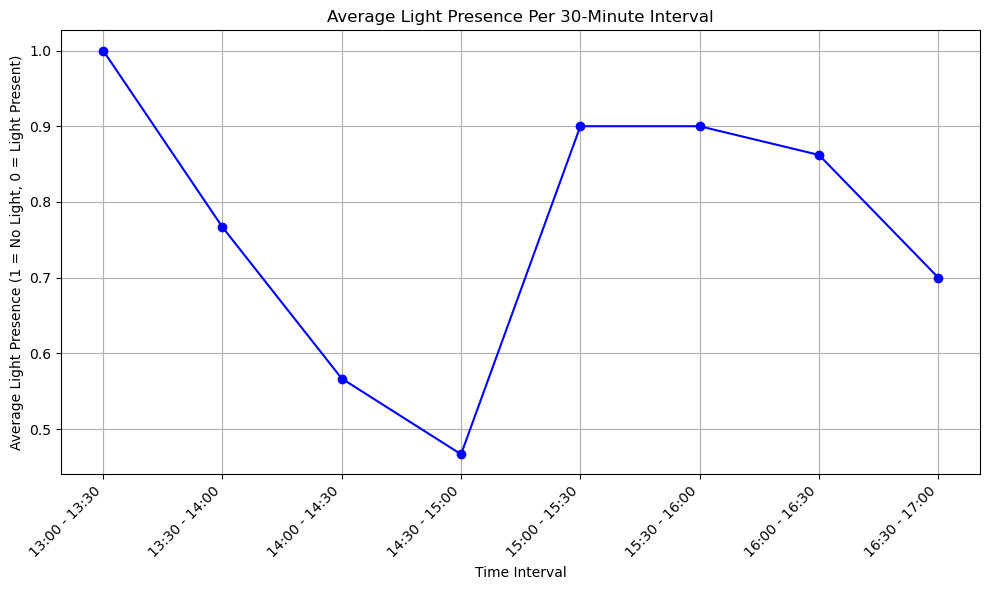

In [16]:
# Discrete line chart for Average light exposure per 30-minute interval

timeIntervals = [doc['_id'] for doc in result_3]
avgLightPresent = [doc['avgLightPresent'] for doc in result_3]

plt.figure(figsize=(10, 6))
plt.plot(timeIntervals, avgLightPresent, marker='o', linestyle='-', color='b', label='Average Light Presence')

plt.xlabel('Time Interval')
plt.ylabel('Average Light Presence (1 = No Light, 0 = Light Present)')
plt.title('Average Light Presence Per 30-Minute Interval')

plt.xticks(rotation=45, ha='right')

plt.grid(True)
plt.tight_layout()
plt.show()

#### 4. Identify peak light exposure times

In [17]:
# This query will identify the hours with the highest frequency of light presence.

In [18]:
pipeline_4 = [
    {"$addFields": {"hour": {"$hour": "$time"}}},
    {"$match": {"time": {"$gte": start_time, "$lte": end_time}}},
    {"$project": {
        "hour": 1,
        "lightPresent": {"$cond": [{"$eq": ["$light_reading", 0]}, 1, 0]}
    }},
    {"$group": {
        "_id": "$hour",
        "totalLightPresent": {"$sum": "$lightPresent"}
    }},
    {"$sort": {"totalLightPresent": -1}}
]

result_4 = list(collection.aggregate(pipeline_4))

print("Peak Light Exposure Times:")
for doc in result_4:
    print(doc)

Peak Light Exposure Times:
{'_id': 15, 'totalLightPresent': 54}
{'_id': 13, 'totalLightPresent': 53}
{'_id': 16, 'totalLightPresent': 46}
{'_id': 14, 'totalLightPresent': 31}


In [19]:
# The count of light readings where light was present (light reading was 0) are grouped and sorted by hour. Hour 15 has 
# the highest frequency with 54 readings followed by hour 13, hour 16 and then hour 14 which had the lowest frequency of 
# light present. 

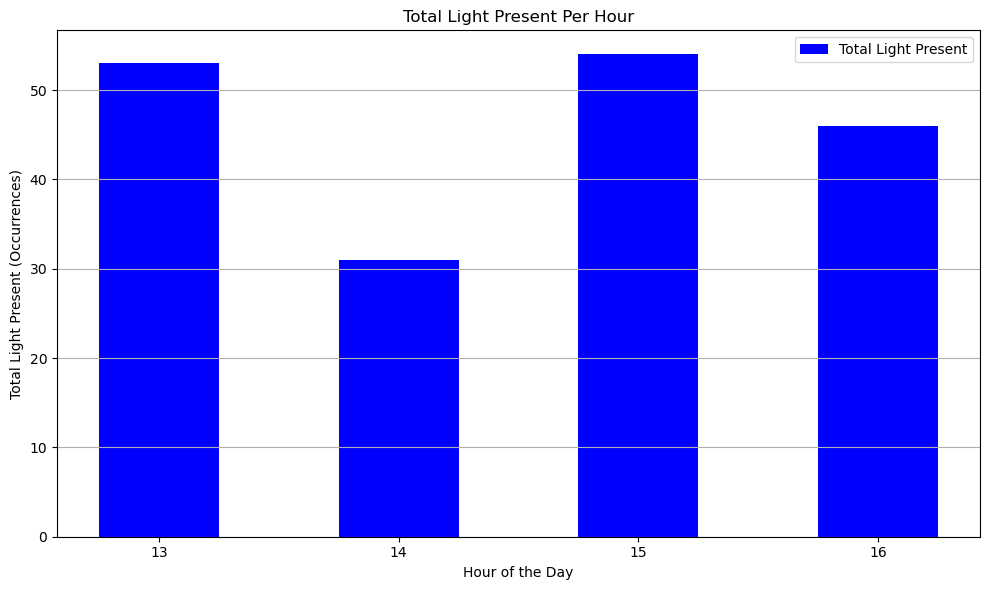

In [20]:
# Grouped column chart for Identify peak light exposure times

hours = [doc['_id'] for doc in result_4]
totalLightPresent = [doc['totalLightPresent'] for doc in result_4]

plt.figure(figsize=(10, 6))
plt.bar(hours, totalLightPresent, color='b', width=0.5, label='Total Light Present')

plt.xlabel('Hour of the Day')
plt.ylabel('Total Light Present (Occurrences)')
plt.title('Total Light Present Per Hour')

plt.xticks(hours)
plt.grid(axis='y')

plt.tight_layout()
plt.legend()
plt.show()

#### 5. Patterns of continuous light presence and absence by hour

In [ ]:
# This query will identify the total duration in minutes of periods of light presence and absence for each hour from 13.00 to 17.00. 

In [22]:
pipeline_5 = [
    # Add fields for hour and minute
    {"$addFields": {
        "hour": {"$hour": "$time"},
        "minute": {"$minute": "$time"}
    }},
    # Filter documents based on time range
    {"$match": {
        "time": {"$gte": start_time, "$lte": end_time}
    }},
    # Sort by time to ensure correct sequence
    {"$sort": {"time": 1}},
    # Add a field to identify changes in light presence
    {"$setWindowFields": {
        "partitionBy": None,
        "sortBy": {"time": 1},
        "output": {
            "prevLightPresent": {
                "$shift": {"output": "$light_reading", "by": -1, "default": None}
            }
        }
    }},
    # Identify periods of continuous light presence or absence
    {"$addFields": {
        "periodType": {
            "$cond": [
                {"$eq": ["$light_reading", "$prevLightPresent"]},
                "$light_reading",
                None
            ]
        }
    }},
    # Group by period type and calculate duration of periods
    {"$group": {
        "_id": {"hour": "$hour", "minute": "$minute", "periodType": "$periodType"},
        "duration": {"$sum": 1}
    }},
    # Filter out null periods
    {"$match": {"_id.periodType": {"$ne": None}}},
    # Group by hour and periodType, calculate total duration
    {"$group": {
        "_id": {"hour": "$_id.hour", "periodType": "$_id.periodType"},
        "totalDuration": {"$sum": "$duration"}
    }},
    # Project results with period type
    {"$project": {
        "hour": "$_id.hour",
        "periodType": "$_id.periodType",
        "totalDuration": 1,
        "_id": 0
    }},
    # Sort by hour and period type
    {"$sort": {"hour": 1, "periodType": 1}}
]

result_5 = list(collection.aggregate(pipeline_5))

print("Patterns of Continuous Light Presence and Absence by Hour:")
for doc in result_5:
    print(doc)

Patterns of Continuous Light Presence and Absence by Hour:
{'totalDuration': 52, 'hour': 13, 'periodType': 0}
{'totalDuration': 6, 'hour': 13, 'periodType': 1}
{'totalDuration': 28, 'hour': 14, 'periodType': 0}
{'totalDuration': 27, 'hour': 14, 'periodType': 1}
{'totalDuration': 52, 'hour': 15, 'periodType': 0}
{'totalDuration': 4, 'hour': 15, 'periodType': 1}
{'totalDuration': 44, 'hour': 16, 'periodType': 0}
{'totalDuration': 10, 'hour': 16, 'periodType': 1}


In [23]:
# Hour represents the hour of the day. Period type indicates whether light was present (0) or absent (1). Total duration is 
# in minutes for the respective period type within that hour.
# Only the continuous periods are considered by using $setwindowfields with $shift to compare each light reading with its 
# previous one which identifies uninterrupted segments. $cond filters out periods where the readings change ensuring only 
# continuous periods of light presence and absence to be considered. 
# For hour 13, light present was 52 minutes and light absent was 6 minutes etc. In hours 13, 15 and 16 light presence is 
# significant with high periods of continuous light. Hour 14 has nearly balanced distribution between light presence and 
# absence while hours 13 and 15 show least light absence periods. 

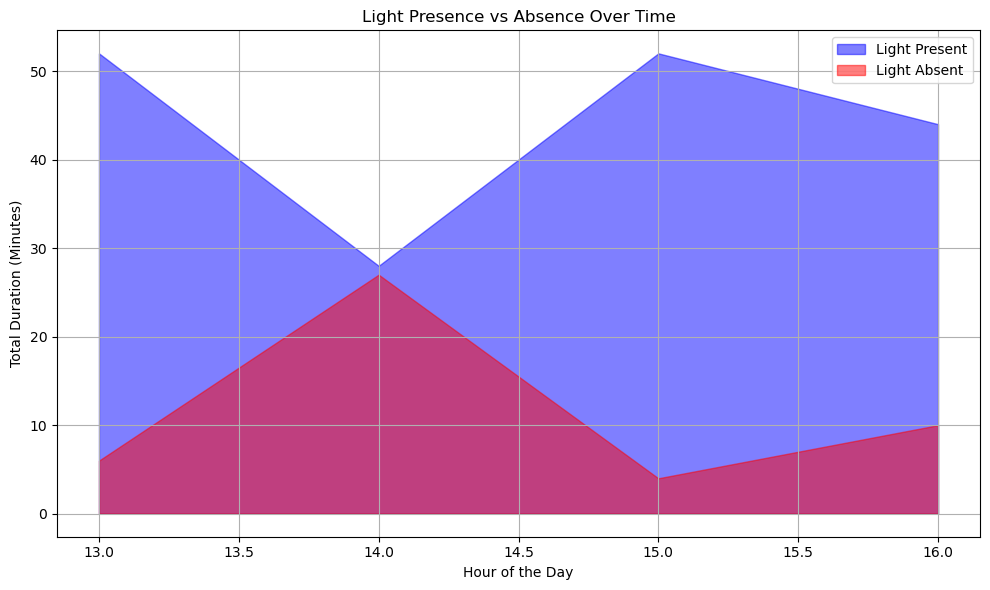

In [24]:
# Continuous area chart for Patterns of continuous light presence and absence by hour

hours = sorted(set([doc['hour'] for doc in result_5]))

lightPresentDict = {doc['hour']: doc['totalDuration'] for doc in result_5 if doc['periodType'] == 0}
lightAbsentDict = {doc['hour']: doc['totalDuration'] for doc in result_5 if doc['periodType'] == 1}

lightPresentDurations = [lightPresentDict.get(hour, 0) for hour in hours]
lightAbsentDurations = [lightAbsentDict.get(hour, 0) for hour in hours]

plt.figure(figsize=(10, 6))

plt.fill_between(hours, lightPresentDurations, label="Light Present", color='b', alpha=0.5)
plt.fill_between(hours, lightAbsentDurations, label="Light Absent", color='r', alpha=0.5)

plt.xlabel('Hour of the Day')
plt.ylabel('Total Duration (Minutes)')
plt.title('Light Presence vs Absence Over Time')

plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### Visualizing Results on Atlas Charts

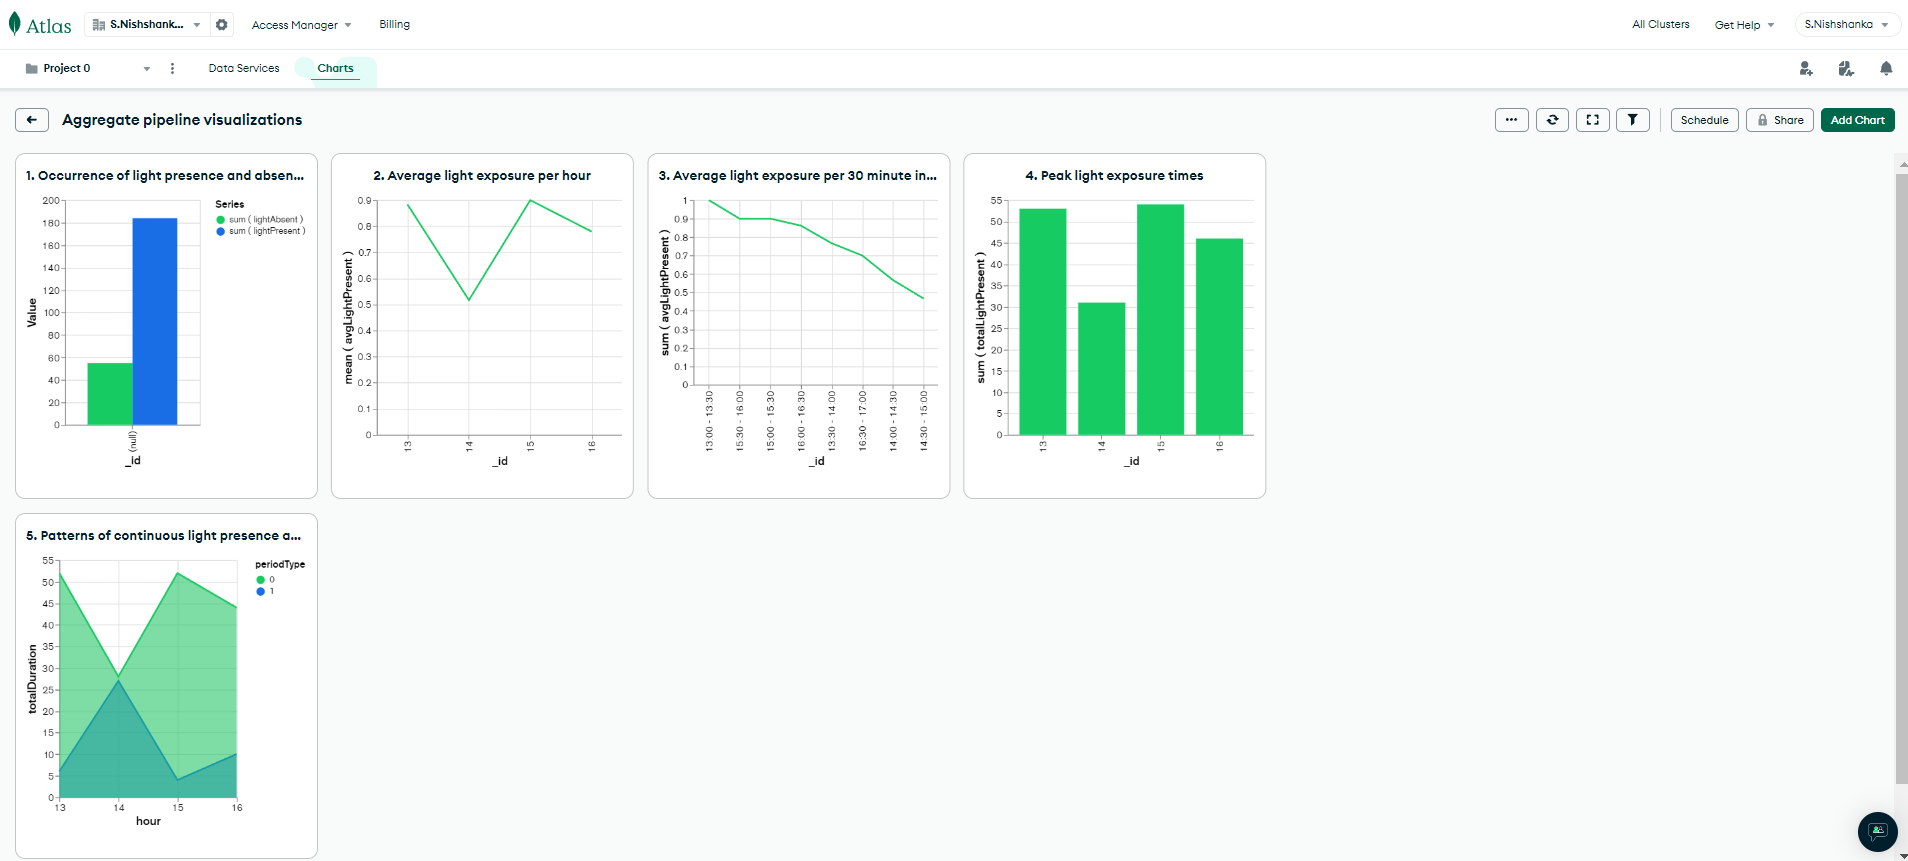

### Visualizing using Dash and Plotly

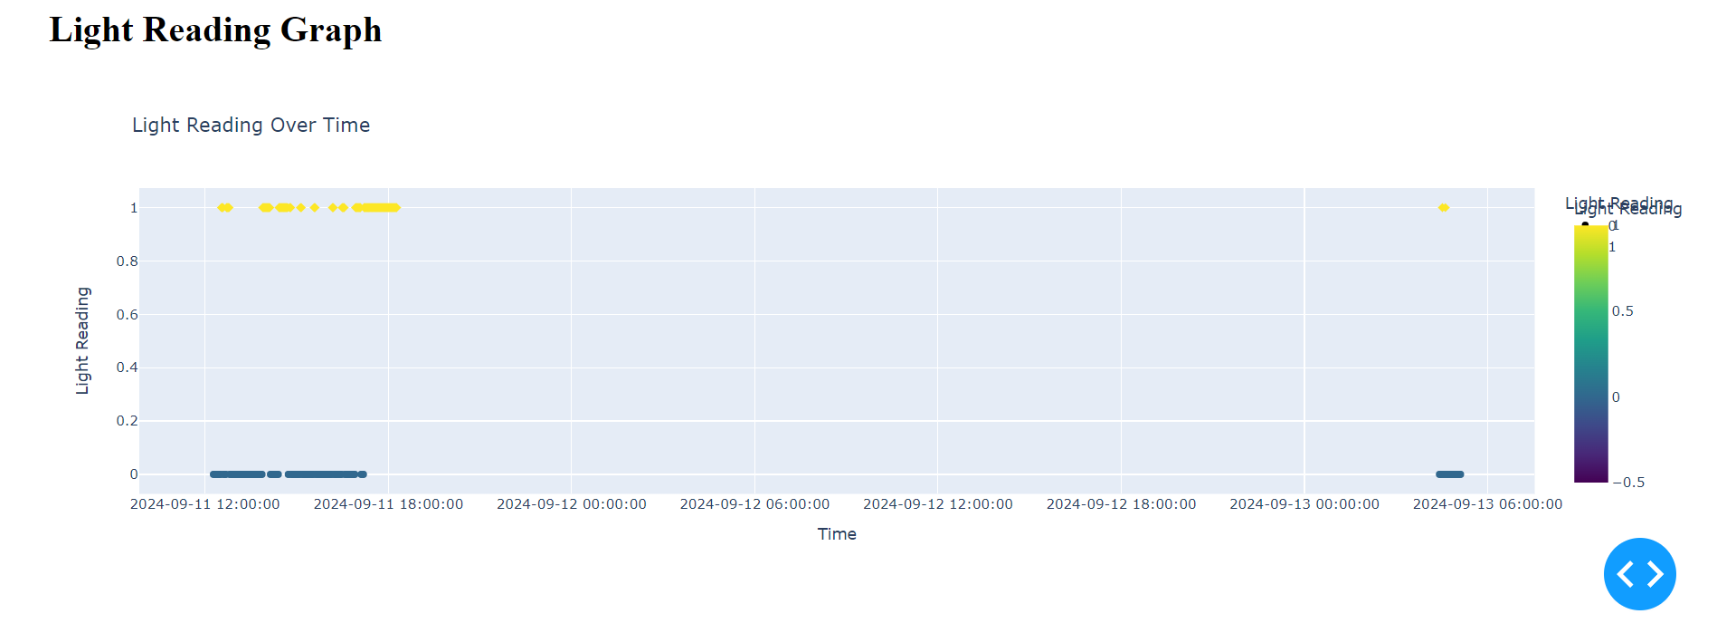